### Data Ingestion (1)

- Data ingestion from ACRA, MasterDB and SSIC mapping, this data will be merged and filter with selected industry to get the specific company havent been researched by MR.

In [3]:
# Standard library
import os
import glob
import re
import time
import asyncio

# Third-party HTTP / async
import requests
import aiohttp
import nest_asyncio

# Data & analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Web scraping
import scrapy
from scrapy_playwright.page import PageMethod
from bs4 import BeautifulSoup

# Fuzzy matching
from fuzzywuzzy import fuzz, process


### Getting Master DB via Google API

In [4]:
# --- OPTIMIZED: Handle timeouts, fetch with retries, and increase timeout limits ---

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import os
import pandas as pd
import re
import socket
import time

sheet_id = '1tQ4HQI_6y9NH3pxtG1xLNIWltLmLn33jL23vExOFCMM'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

SERVICE_ACCOUNT_FILE = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "credentials.json")
if not os.path.exists(SERVICE_ACCOUNT_FILE):
    raise FileNotFoundError(
        f"Service account file not found at '{SERVICE_ACCOUNT_FILE}'. "
        "Set GOOGLE_APPLICATION_CREDENTIALS to the full path, or place credentials.json next to this notebook."
    )

# --- FIX: Set timeout BEFORE building the service ---
socket.setdefaulttimeout(300)  # 5 minutes - MUST be set before build()

credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=credentials)
sheet = service.spreadsheets()

range_a1 = "'MASTER_TABLE'!A:ZZ"

# --- Fetch with retry logic ---
max_retries = 3
retry_count = 0
values = None

while retry_count < max_retries:
    try:
        print(f"Fetching data from Google Sheets (attempt {retry_count + 1}/{max_retries})...")
        result = sheet.values().get(
            spreadsheetId=sheet_id,
            range=range_a1
        ).execute()
        values = result.get('values', [])
        print("✅ Data fetched successfully!")
        break
    except (socket.timeout, TimeoutError) as e:
        retry_count += 1
        if retry_count < max_retries:
            wait_time = 2 * retry_count  # Exponential backoff: 2s, 4s, 6s
            print(f"⚠️ Timeout occurred: {type(e).__name__}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
            time.sleep(wait_time)
        else:
            print("❌ Failed after maximum retries. Try reducing the range or check your connection.")
            raise
    except Exception as e:
        error_str = str(e).lower()
        if any(keyword in error_str for keyword in ['timeout', 'timed out', 'connection', 'network']):
            retry_count += 1
            if retry_count < max_retries:
                wait_time = 2 * retry_count
                print(f"⚠️ Network error: {e}. Retrying in {wait_time}s... ({retry_count}/{max_retries})")
                time.sleep(wait_time)
            else:
                print("❌ Failed after maximum retries due to network issues.")
                raise
        else:
            print(f"❌ Non-retryable error: {e}")
            raise

if values:
    header = values[0]
    data_rows = values[1:]

    max_len = max([len(header)] + [len(r) for r in data_rows]) if data_rows else len(header)

    if len(header) < max_len:
        header = header + [f'col_{i+1}' for i in range(len(header), max_len)]

    normalized_rows = [row + [''] * (max_len - len(row)) for row in data_rows]

    Master_DB_df = pd.DataFrame(normalized_rows, columns=header)
    print(f"Successfully loaded {len(Master_DB_df)} rows and {len(Master_DB_df.columns)} columns")
else:
    Master_DB_df = pd.DataFrame()
    print("No data found in the sheet")

# ---------------- CLEANING FUNCTIONS ----------------

def clean_ssic_code(value):
    if pd.isna(value) or value == '':
        return None
    try:
        cleaned = re.sub(r"[^0-9]", "", str(value).strip())
        return int(cleaned) if cleaned else None
    except (ValueError, TypeError):
        return None

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = [
        re.sub(r"_+", "_", re.sub(r"[^A-Z0-9]", "_", col.upper().strip())).strip("_")
        for col in df.columns
    ]
    df.columns = new_cols
    return df

# ---------------- PROCESS MASTER DB ----------------

columns_to_keep = [
    "Company Registration Number (UEN)",
    "ACRA REGISTERED NAME",
    "Brand/Deal Name/Business Name",
    "Primary SSIC Code",
    "PIC NAME 1 Contact Number",
    "PIC 1 email address",
    "Website URL",
    "Parent Industry Type",
    "Sub Industry"
]

existing_cols = [c for c in columns_to_keep if c in Master_DB_df.columns]
if not existing_cols:
    raise ValueError("None of the required columns found in the dataframe")

master_db_df = Master_DB_df[existing_cols].copy()
master_db_df = standardize_columns(master_db_df)

uen_cols = [c for c in master_db_df.columns if "UEN" in c]
if not uen_cols:
    raise ValueError("UEN column not found after standardization")

uen_col = uen_cols[0]

master_db_df["UEN"] = (
    master_db_df[uen_col].astype(str).str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)
)
master_db_df["UEN"] = master_db_df["UEN"].replace(['', 'NAN', 'NONE'], None)
master_db_df = master_db_df.drop(columns=[uen_col])

rename_map = {
    "BRAND_DEAL_NAME_BUSINESS_NAME": "BRAND_NAME",
    "PRIMARY_SSIC_CODE": "SSIC_CODE",
}

master_db_df = master_db_df.rename(columns={k: v for k, v in rename_map.items() if k in master_db_df.columns})

for col in ["ACRA_REGISTERED_NAME", "BRAND_NAME"]:
    if col in master_db_df.columns:
        master_db_df[col] = (
            master_db_df[col].astype(str).str.strip().str.upper().replace(['', 'NAN', 'NONE'], None)
        )

if "SSIC_CODE" in master_db_df.columns:
    master_db_df["SSIC_CODE"] = master_db_df["SSIC_CODE"].apply(clean_ssic_code)

required_cols = ["UEN", "ACRA_REGISTERED_NAME", "BRAND_NAME", "SSIC_CODE"]
available_cols = [c for c in required_cols if c in master_db_df.columns]
master_db_df = master_db_df[available_cols].copy()

master_db_df = master_db_df[
    master_db_df["UEN"].notna() & (master_db_df["UEN"].astype(str).str.strip() != "")
]

print(f"Final dataset: {len(master_db_df)} rows, {len(master_db_df.columns)} columns")
master_db_df


Fetching data from Google Sheets (attempt 1/3)...
✅ Data fetched successfully!
Successfully loaded 36139 rows and 86 columns
Final dataset: 35469 rows, 4 columns


,UEN,ACRA_REGISTERED_NAME,BRAND_NAME,SSIC_CODE
0,201432377N,RUE MADAME SING PTE. LTD.,RUE MADAME,47510.0
1,53497312D,ABANG BONS KITCHEN LLP,ABANG BONS KITCHEN,56123.0
2,T24LL1132L,ARTISAN TEH TARIK,ARTISAN TEH TARIK,56123.0
3,T25LL0283D,AFTERMIDNIGHT LLP,AFTERMIDNIGHT,59119.0
4,T25LL0241C,ADDICTIVE ADDICTIVES LLP,ADDICTIVE ADDICTIVES,63201.0
...,...,...,...,...
36134,199301874Z,GERMAXCO SHIPPING AGENCIES PTE LTD,GERMAXCO SHIPPING AGENCIES HQ,52222.0
36135,201629314H,GERMAXCO PTE. LTD.,GERMAXCO,52101.0
36136,199204539E,GILMON TRANSPORTATION & WAREHOUSING PTE LTD,GILMON TRANSPORTATION & WAREHOUSING,52101.0
36137,53464472D,GLOBAL HUB LACIS,GLOBAL HUB LACIS,52101.0


### Getting ACRA Data (Filter by Live, Live Company only & non relevant ssic code)
- last downloaded jan 27

In [5]:

folder_path = "Acra_Data"

# Get all CSV file paths inside the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine all CSVs
# Using low_memory=False to avoid DtypeWarning for mixed types
df = pd.concat((pd.read_csv(f, low_memory=False) for f in csv_files), ignore_index=True)


df.columns = df.columns.str.upper()


acra_data = df[[
    "UEN",
    "ENTITY_NAME",
    "BUSINESS_CONSTITUTION_DESCRIPTION",
    "ENTITY_TYPE_DESCRIPTION",
    "ENTITY_STATUS_DESCRIPTION",
    "REGISTRATION_INCORPORATION_DATE",
    "PRIMARY_SSIC_CODE",
    "SECONDARY_SSIC_CODE",
    "STREET_NAME",
    "POSTAL_CODE"
]].copy()

# Convert to proper data types
acra_data['UEN'] = acra_data['UEN'].astype('string')
acra_data['ENTITY_NAME'] = acra_data['ENTITY_NAME'].astype('string')
acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'] = acra_data['BUSINESS_CONSTITUTION_DESCRIPTION'].astype('string')
acra_data['ENTITY_TYPE_DESCRIPTION'] = acra_data['ENTITY_TYPE_DESCRIPTION'].astype('string')
acra_data['ENTITY_STATUS_DESCRIPTION'] = acra_data['ENTITY_STATUS_DESCRIPTION'].astype('string')
acra_data['REGISTRATION_INCORPORATION_DATE'] = pd.to_datetime(acra_data['REGISTRATION_INCORPORATION_DATE'], errors='coerce')

# Clean string columns — trim, remove extra spaces, uppercase
for col in [
    'UEN',
    'ENTITY_NAME',
    'BUSINESS_CONSTITUTION_DESCRIPTION',
    'ENTITY_TYPE_DESCRIPTION',
    'ENTITY_STATUS_DESCRIPTION',
    'STREET_NAME',
    'POSTAL_CODE'
]:
    acra_data[col] = (
        acra_data[col]
        .fillna('')
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
        .str.upper()
    )

# Replace placeholders with NaN for standardization
acra_data.replace(['NA', 'N/A', '-', ''], np.nan, inplace=True)

# Convert registration date to dd-mm-yyyy string (optional)
acra_data['REGISTRATION_INCORPORATION_DATE'] = acra_data['REGISTRATION_INCORPORATION_DATE'].dt.strftime('%d-%m-%Y')

# Filter only live entities (LIVE COMPANY or LIVE)
acra_data = acra_data[
    acra_data['ENTITY_STATUS_DESCRIPTION'].isin(['LIVE COMPANY', 'LIVE'])
].reset_index(drop=True)

# Exclude specific PRIMARY_SSIC_CODE values (supposedly the data would be 600k plus but when we exclude this would lessen)
exclude_codes = [
    46900, 47719, 47749, 47539, 47536, 56123,
    10711, 10712, 10719, 10732, 10733, 93209
]

acra_data = acra_data[~acra_data['PRIMARY_SSIC_CODE'].isin(exclude_codes)].reset_index(drop=True)

In [6]:
acra_data

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623
...,...,...,...,...,...,...,...,...,...,...
539425,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969
539426,T25LL1033K,ZAYNTCG LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,03-09-2025,47640,na,TELOK BLANGAH WAY,090027
539427,T25LL1066B,ZDT DRIVES LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,14-09-2025,47533,29300,FERNVALE ROAD,792466
539428,T25LL1186C,ZESTE BRANDS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,06-10-2025,47220,na,BEACH ROAD,199589


### Getting SSIC Industry code

In [7]:
# --- CONFIG ---
file_path = "./SSIC_Code/mapped_ssic_code.xlsx"

# --- LOAD DATA ---
mapped_ssic_code = pd.read_excel(file_path)

# --- STANDARDIZE COLUMN NAMES ---  
# Uppercase, strip spaces, replace spaces with underscores
mapped_ssic_code.columns = (
    mapped_ssic_code.columns
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

# --- KEEP ONLY DESIRED COLUMNS ---
columns_to_keep = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "SSIC_CODES", "DESCRIPTION"]
mapped_ssic_code = mapped_ssic_code[columns_to_keep].copy()

# --- CLEAN SSIC_CODES COLUMN ---
mapped_ssic_code["SSIC_CODES"] = (
    pd.to_numeric(mapped_ssic_code["SSIC_CODES"], errors="coerce")  # safely convert to numeric
    .fillna(0)
    .astype(int)
)

# --- CLEAN TEXT COLUMNS ---
text_cols = ["PARENT_INDUSTRY", "INDUSTRY_TYPE", "SUB_INDUSTRY", "DESCRIPTION"]
mapped_ssic_code[text_cols] = mapped_ssic_code[text_cols].apply(
    lambda col: col.astype(str).str.strip().str.title()
)

# --- REMOVE DUPLICATES & RESET INDEX ---
mapped_ssic_code = mapped_ssic_code.drop_duplicates().reset_index(drop=True)

mapped_ssic_code.head()


,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,SSIC_CODES,DESCRIPTION
0,Retail,Retail,Fashion & Apparel,47711,Retail Sale Of Clothing For Adults
1,Retail,Retail,Fashion & Apparel,47712,Retail Sale Of Children And Infants' Clothing
2,Retail,Retail,Fashion & Apparel,47715,Retail Sale Of Sewing And Clothing Accessories
3,Retail,Retail,Fashion & Apparel,47719,"Retail Sale Of Clothing, Footwear And Leather ..."
4,Retail,Retail,Fashion & Apparel,47510,Retail Sale Of Textiles


### Merge ACRA data with SSIC code

In [8]:
# Convert PRIMARY_SSIC_CODE to int
acra_data["PRIMARY_SSIC_CODE"] = (
    pd.to_numeric(acra_data["PRIMARY_SSIC_CODE"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Merge based on SSIC code
acra_data_filtered = acra_data.merge(
    mapped_ssic_code,
    how="left",
    left_on="PRIMARY_SSIC_CODE",
    right_on="SSIC_CODES"
)

# Optional: drop the duplicate 'SSIC CODES' column (keep only PRIMARY_SSIC_CODE)
acra_data_filtered = acra_data_filtered.drop(columns=["SSIC_CODES"], errors="ignore")


### FIlter Acra data with Master DB to get list of companies havent been researched  by MR

In [9]:

# Ensure both UEN columns are strings for accurate matching
acra_data_filtered['UEN'] = acra_data_filtered['UEN'].astype(str).str.strip().str.upper()
master_db_df['UEN'] = master_db_df['UEN'].astype(str).str.strip().str.upper()

# Filter out rows in acra_data_filtered whose UEN is already in master_db_df
acra_data_filtered = acra_data_filtered[~acra_data_filtered['UEN'].isin(master_db_df['UEN'])]

acra_data_filtered.shape

(511720, 14)

In [10]:
acra_data_filtered

,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
0,00182000A,AIK SENG HENG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,07-02-1975,46302,na,FISHERY PORT ROAD,619742,Others,Wholesale Trade,"Food, Beverages & Tobacco","Wholesale Of Livestock, Meat, Poultry, Eggs An..."
1,00233500W,ASIA STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,28-10-1974,46411,20234,SIMS AVENUE,387509,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
2,00733000J,AIK CHE HIONG,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,02-11-1974,32909,46900,ANG MO KIO INDUSTRIAL PARK 2A,568049,Others,Manufacturing,Other Specialised Manufacturing & Distribution,Other Manufacturing Industries N.E.C.
3,00927000X,A WALIMOHAMED BROS,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,12-11-1974,46411,66126,JELLICOE ROAD,208767,Others,Wholesale Trade,Household Goods,Wholesale Of Textiles And Leathers
4,01173000E,ANG TECK MOH DEPARTMENT STORE,PARTNERSHIP,SOLE PROPRIETORSHIP/ PARTNERSHIP,LIVE,30-10-1974,47711,47214,WOODLANDS STREET 12,738623,Retail,Retail,Fashion & Apparel,Retail Sale Of Clothing For Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539425,T25LL0870A,ZIQZEQ PROCUREMENT LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,04-08-2025,70209,46100,SIN MING LANE,573969,Others,"Finance, Legal & Real Estate","Legal, Accounting & Consultancy Activities",Management Consultancy Services N.E.C.
539426,T25LL1033K,ZAYNTCG LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,03-09-2025,47640,na,TELOK BLANGAH WAY,090027,Retail,Retail,"Specialty Stores (Books, Toys, Sports, Etc.)",Retail Sale Of Games And Toys
539427,T25LL1066B,ZDT DRIVES LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,14-09-2025,47533,29300,FERNVALE ROAD,792466,NaN,NaN,NaN,NaN
539428,T25LL1186C,ZESTE BRANDS LLP,<NA>,LIMITED LIABILITY PARTNERSHIP,LIVE,06-10-2025,47220,na,BEACH ROAD,199589,Retail,Retail,"Wet Markets, Market Stalls & Street Retailers",Retail Sale Of Beverages


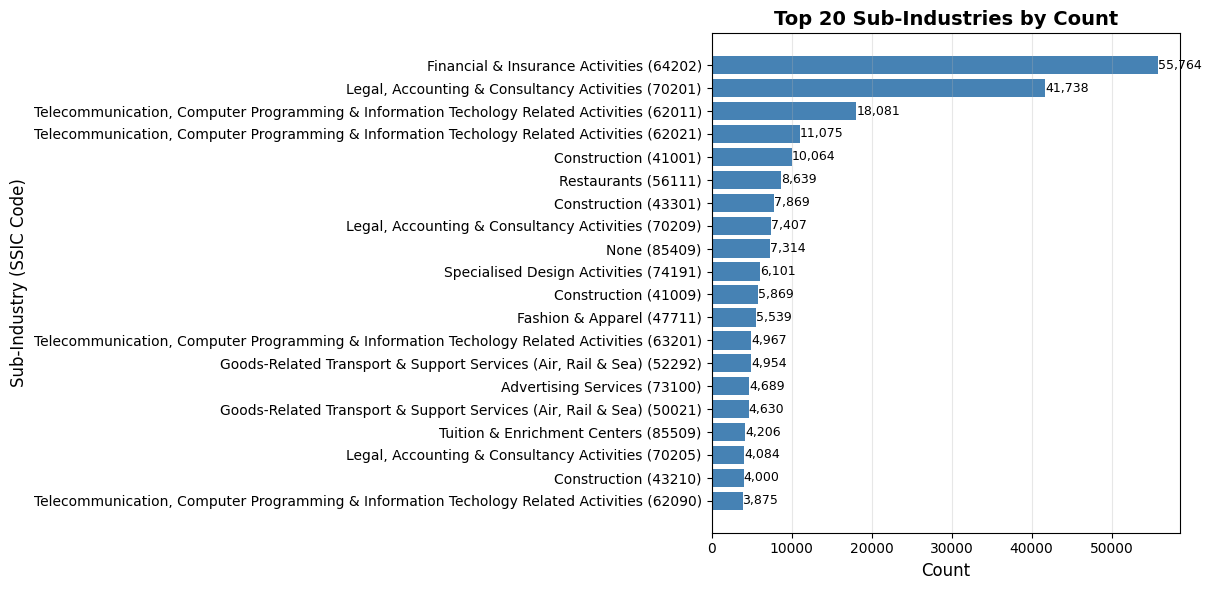


Top 20 SSIC codes with Sub-Industry names:
64202 - Financial & Insurance Activities: 55,764
70201 - Legal, Accounting & Consultancy Activities: 41,738
62011 - Telecommunication, Computer Programming & Information Techology Related Activities: 18,081
62021 - Telecommunication, Computer Programming & Information Techology Related Activities: 11,075
41001 - Construction: 10,064
56111 - Restaurants: 8,639
43301 - Construction: 7,869
70209 - Legal, Accounting & Consultancy Activities: 7,407
85409 - None: 7,314
74191 - Specialised Design Activities: 6,101
41009 - Construction: 5,869
47711 - Fashion & Apparel: 5,539
63201 - Telecommunication, Computer Programming & Information Techology Related Activities: 4,967
52292 - Goods-Related Transport & Support Services (Air, Rail & Sea): 4,954
73100 - Advertising Services: 4,689
50021 - Goods-Related Transport & Support Services (Air, Rail & Sea): 4,630
85509 - Tuition & Enrichment Centers: 4,206
70205 - Legal, Accounting & Consultancy Activities: 

In [11]:
# Count the values in PRIMARY_SSIC_CODE column and get top 10
ssic_counts = acra_data_filtered['PRIMARY_SSIC_CODE'].value_counts().head(20)

# Create a mapping of SSIC code to SUB_INDUSTRY name
ssic_to_subindustry = acra_data_filtered.groupby('PRIMARY_SSIC_CODE')['SUB_INDUSTRY'].first()

# Create labels with both SSIC code and SUB_INDUSTRY name
labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in ssic_counts.index]

# Sort by count (ascending for horizontal bar chart)
sorted_indices = ssic_counts.sort_values(ascending=True).index
sorted_counts = ssic_counts.sort_values(ascending=True).values
sorted_labels = [f"{ssic_to_subindustry.get(code, 'Unknown')} ({code})" for code in sorted_indices]

# Create horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(sorted_labels, sorted_counts, color='steelblue')

# Add count labels on each bar
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{count:,}', va='center', fontsize=9)

plt.xlabel('Count', fontsize=12)
plt.ylabel('Sub-Industry (SSIC Code)', fontsize=12)
plt.title('Top 20 Sub-Industries by Count', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTop 20 SSIC codes with Sub-Industry names:")
for code in ssic_counts.sort_values(ascending=False).index:
    count = ssic_counts[code]
    subindustry = ssic_to_subindustry.get(code, 'Unknown')
    print(f"{code} - {subindustry}: {count:,}")

### Filter by  Industry

-   after 2020

In [12]:
# Event Organizer
# 75000 (vet), 86204 (Dental), ""

# spas
ssic_codes = [
    "85509"]

from datetime import datetime, timedelta

# Convert to datetime FIRST (before any filtering)
acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] = pd.to_datetime(
    acra_data_filtered["REGISTRATION_INCORPORATION_DATE"],
    dayfirst=True,
    errors="coerce"
)

current_date = datetime.now()
ten_years_ago = current_date - timedelta(days=10*365.25)  # Account for leap years

# Now filter by industry, status, and date all at once
acra_data_filtered_by_industry = acra_data_filtered[
    (
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live") |
        (acra_data_filtered["ENTITY_STATUS_DESCRIPTION"].str.lower() == "live company")
    )
    &
    (acra_data_filtered["PRIMARY_SSIC_CODE"].astype(str).isin(ssic_codes))
    # &
    # (acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] > ten_years_ago)
    # &
    # (acra_data_filtered["REGISTRATION_INCORPORATION_DATE"] <= current_date)
]

# Convert date to dd/mm/yyyy format for display
acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] = (
    acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"].dt.strftime("%d/%m/%Y")
)

print(acra_data_filtered_by_industry.shape)
acra_data_filtered_by_industry.head(10)

(4206, 14)


C:\Users\azlie\AppData\Local\Temp\ipykernel_4568\3486082040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acra_data_filtered_by_industry["REGISTRATION_INCORPORATION_DATE"] = (


,UEN,ENTITY_NAME,BUSINESS_CONSTITUTION_DESCRIPTION,ENTITY_TYPE_DESCRIPTION,ENTITY_STATUS_DESCRIPTION,REGISTRATION_INCORPORATION_DATE,PRIMARY_SSIC_CODE,SECONDARY_SSIC_CODE,STREET_NAME,POSTAL_CODE,PARENT_INDUSTRY,INDUSTRY_TYPE,SUB_INDUSTRY,DESCRIPTION
4179,200613314G,ASCEND INTERNATIONAL TRAINING PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,11/09/2006,85509,88912,GOLDHILL PLAZA,308899,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
4585,200708627D,ART BUILDERZ PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,16/05/2007,85509,na,SIN MING LANE,573969,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
4759,200715323E,ACP COMPUTER TRAINING SCHOOL PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,20/08/2007,85509,85409,ANG MO KIO STREET 62,569139,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
4881,200721644W,ATHLETE DEVELOPMENT PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,21/11/2007,85509,85409,EASTWOOD ROAD,486442,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
5073,200806301Z,ADDCEL EDU CONSULTANCY (PTE.) LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,01/04/2008,85509,na,HOUGANG STREET 51,530566,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
5539,200902560M,ALPHA EDUCATION CONSULTANTS PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,12/02/2009,85509,85501,CHOA CHU KANG STREET 54,680768,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
5590,200904900G,AUTISM RECOVERY NETWORK (SINGAPORE) PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,19/03/2009,85509,na,JOO CHIAT ROAD,427671,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
5743,200910650Z,ABC CENTER PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,12/06/2009,85509,na,SOMERSET ROAD,238164,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
5791,200912105K,ACCENDO LEARNERS' HUB PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,04/07/2009,85509,88912,BUKIT BATOK WEST AVENUE 5,651395,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.
6089,200923394W,AG EDUCATION PTE. LTD.,<NA>,LOCAL COMPANY,LIVE COMPANY,15/12/2009,85509,na,JALAN AWANG,419644,Others,Educational,Tuition & Enrichment Centers,Training Courses N.E.C.


### Get the sample data

In [13]:
acra_data_filtered_by_industry.shape

(4206, 14)

### filter with scrapped

In [14]:
# ### Filter with scrapped data 

# recordOwlData_1 = pd.read_parquet("./Staging/Silver/Silver_data_spa.parquet", engine="fastparquet")
# recordOwlData_1

# acra_data_filtered_by_industry = acra_data_filtered_by_industry[~acra_data_filtered_by_industry['UEN'].isin(recordOwlData_1['UEN'])]
# acra_data_filtered_by_industry

In [15]:
# # get sample data 
# acra_data_filtered_by_industry = acra_data_filtered_by_industry.sample(n=100).reset_index(drop=True)

# print(acra_data_filtered_by_industry.shape)
# acra_data_filtered_by_industry.tail(10)


In [16]:
print(acra_data_filtered_by_industry.shape)
print(acra_data_filtered_by_industry["UEN"].is_unique)


(4206, 14)
True


In [17]:
acra_data_filtered_by_industry.to_parquet("./Staging/Bronze/bronze_data_1.parquet", index=False, engine="fastparquet")